In [1]:
import string
import re
import os
import nltk
import pandas as pd
import numpy as np
import json
import tensorflow as tf
from tensorflow import keras
SEED = 1013
np.random.seed(SEED)
#nltk.download('stopwords')
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords, twitter_samples 
from stance_utils import *
#from parameters import *
from nltk.stem import PorterStemmer
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential
#from tensorflow.keras.layers import Dropout,Concatenate,Dense, Embedding, SpatialDropout1D, Flatten, GRU, Bidirectional, Conv1D,MaxPooling1D

from tensorflow.keras.layers import RNN, Dropout,Concatenate,Dense, Embedding,LSTMCell, LSTM, SpatialDropout1D, Flatten, GRU, Bidirectional, Conv1D, Input,MaxPooling1D
from sklearn.model_selection import train_test_split
from tensorflow.keras import Model
from sklearn.model_selection import StratifiedKFold
stemmer = PorterStemmer()
tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
stopwords_english = stopwords.words('english')
from sklearn.preprocessing import LabelEncoder
import keras.backend as K
from keras.layers import Lambda
import random
import matplotlib.pyplot as plt

In [2]:
classes = {'FAVOR': np.array([1, 0, 0]), 'AGAINST': np.array([0, 1, 0]), 'NONE': np.array([0, 0, 1])}
classes_ = np.array(['FAVOR', 'AGAINST', 'NONE'])

In [3]:
batch_size = 16
setting = 'cross' #'in' or 'cross'
units = 60

In [4]:
train_data_file_m = '/data/parush/stance_mohammed/new_train.txt'
test_data_file_m = '/data/parush/stance_mohammed/new_test.txt'
TARGETS_m = [ 'Atheism','Climate Change is a Real Concern', 'Feminist Movement','Hillary Clinton', 'Legalization of Abortion', 'Donald Trump']

In [5]:
def train_and_test(train_file, test_file, target):
    
    sentence_maxlen = 0
    target_maxlen = 0
    x_s_token = []
    x_t_token = []
    y_train = []

    print('Using', target)
    with open(train_file, 'r') as trainfile:
        for line in trainfile: 
            line = line.replace('#SemST', '').strip()
            line = line.split('\t')
            
            
            if line[0].strip() != 'ID' and target in line[1].strip():
                tweet = line[2]
                tweet = process_tweet(tweet)
                if len(tweet) > sentence_maxlen:
                    sentence_maxlen = len(tweet)
                x_s_token.append(tweet)
                target_ = line[1].strip().lower().split()
                if len(target_) > target_maxlen:
                    target_maxlen = len(target_)
                x_t_token.append(target_)
                y_train.append(classes[line[3].strip()])
    

                               
    
    x_s_test_token = []
    x_t_test_token = []
    y_test = []
    with open(test_file, 'r') as testfile:
        for line in testfile:
            line = line.replace('#SemST', '').strip()
            line = line.split('\t')
        

            
            if line[0] != 'ID' and target in line[1].strip():
                tweet = line[2]
                tweet = process_tweet(tweet)
                if len(tweet) > sentence_maxlen:
                    sentence_maxlen = len(tweet)
                x_s_test_token.append(tweet)
                target_ = line[1].strip().lower().split()
                if len(target_) > target_maxlen:
                    target_maxlen = len(target_)
                x_t_test_token.append(target_)
                y_test.append(classes[line[3].strip()])


    
    return x_s_token, x_t_token, x_s_test_token, x_t_test_token, y_train, y_test, sentence_maxlen, target_maxlen

In [6]:
if setting == 'in':
    x_s_token, x_t_token, x_s_test_token, x_t_test_token, y_train, y_test, sentence_maxlen, target_maxlen  = train_and_test(train_data_file_m, test_data_file_m, TARGETS_m[2])
if setting == 'cross':
    x_s_token, x_t_token, _, _, y_train, _, sentence_maxlen, target_maxlen  = train_and_test(train_data_file_m, test_data_file_m, TARGETS_m[2])
    _, _, x_s_test_token, x_t_test_token, _, y_test, _, _  = train_and_test(train_data_file_m, test_data_file_m, TARGETS_m[4])
    

Using Feminist Movement
Using Legalization of Abortion


In [7]:
vocabulary = build_vocab(x_s_token + x_t_token )
vocab_size = len(vocabulary)
print("Total words in vocab are",vocab_size)

Total words in vocab are 2349


In [8]:
y_train = np.asarray(y_train)
_,balance = divmod(len(y_train),batch_size)
balance = batch_size-balance
y_train = list(y_train)
for i in range(balance):
    index = np.random.randint(1, len(y_train))
    x_s_token.append(x_s_token[index])
    y_train.append(y_train[index])
    x_t_token.append(x_t_token[index])

In [9]:
x_s = [tweet_to_tensor(each_s,vocabulary) for each_s in x_s_token]
x_s = pad_sequences(x_s, maxlen = sentence_maxlen, padding = 'post')
x_s_test = [tweet_to_tensor(each_s,vocabulary) for each_s in x_s_test_token]
x_s_test = pad_sequences(x_s_test, maxlen = sentence_maxlen, padding = 'post')

x_t = [tweet_to_tensor(each_s,vocabulary) for each_s in x_t_token]
x_t = pad_sequences(x_t, maxlen = sentence_maxlen, padding = 'post')
x_t_test = [tweet_to_tensor(each_s,vocabulary) for each_s in x_t_test_token]
x_t_test = pad_sequences(x_t_test, maxlen = sentence_maxlen, padding = 'post')

In [10]:
shuffle_indices = np.random.permutation(np.arange(len(y_train)))
x_s = x_s[shuffle_indices]
x_t = x_t[shuffle_indices]
y_train = np.asarray(y_train)
y_train = y_train[shuffle_indices]
y_test = np.asarray(y_test)

In [11]:
embedding_matrix = get_embeddings('twitter',100,vocabulary)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


In [12]:
embedded_inputs = tf.nn.embedding_lookup(embedding_matrix, x_t)

2021-10-30 22:08:58.917886: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /apps/cuda/cuda-11.2/lib64:/slurm/include
2021-10-30 22:08:58.917940: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-10-30 22:08:58.917971: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (gaivi2.cse.usf.edu): /proc/driver/nvidia/version does not exist
2021-10-30 22:08:58.918580: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
embedded_inputs.shape

TensorShape([672, 18, 100])

In [14]:
h_0 = tf.convert_to_tensor(np.zeros([batch_size, units]).astype(np.float32))
c_0 = tf.convert_to_tensor(np.zeros([batch_size, units]).astype(np.float32))
start_state = [h_0, c_0]

In [15]:
inputs = embedded_inputs[:batch_size]


In [16]:
inputs.shape

TensorShape([16, 18, 100])

In [17]:


lstm = LSTM(units, return_sequences=True, return_state=True)
fw_output, fw_h_0, fw_c_0 = lstm(inputs,initial_state = [h_0, c_0])
bw_output, bw_h_0, bw_c_0 = lstm(inputs[::-1],initial_state = [h_0, c_0]) # feeding data backwords



In [18]:
# opt = keras.optimizers.Adam(learning_rate=1e-3)
# inputs2 = Input(shape=(sentence_maxlen), name = 'Input')

# embedded_inputs = Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1], weights=[embedding_matrix], name = 'Embedding')(inputs2)

# lstm = LSTM(units,activation='tanh',dropout=0.1,name = 'lstm')(embedded_inputs, initial_state = [h_0, fw_c_0])
# b_lstm = LSTM(units,activation='tanh',dropout=0.1, go_backwards = True,name = 'back_lstm')(embedded_inputs, initial_state = [h_0, bw_c_0])
# cond_out = []
# cond_out.append(lstm)
# cond_out.append(b_lstm)
# concat_output = Concatenate()(cond_out)
# flat = Flatten(name = 'Flatten')(concat_output)
# output = (Dense(3,activation='softmax',name = 'Dense'))(flat)
# model2 = Model(inputs=inputs2, outputs=output)
# model2.compile(loss = 'categorical_crossentropy', optimizer=opt, metrics = ['accuracy'])    
# model2.summary()


In [19]:
opt = keras.optimizers.Adam(learning_rate=1e-3)
inputs2 = Input(shape=(sentence_maxlen), name = 'Input')

embedded_inputs = Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1], weights=[embedding_matrix], name = 'Embedding')(inputs2)

lstm = LSTM(units,activation='tanh',dropout=0.1,name = 'lstm')(embedded_inputs, initial_state = [h_0, fw_c_0])
b_lstm = LSTM(units,activation='tanh',dropout=0.1, go_backwards = True,name = 'back_lstm')(embedded_inputs, initial_state = [h_0, bw_c_0])
cond_out = []
cond_out.append(lstm)
cond_out.append(b_lstm)
concat_output = Concatenate()(cond_out)
concat_output = Dropout(0.5)(concat_output)
flat = Flatten(name = 'Flatten')(concat_output)
output = Dropout(0.5)(flat)
output = (Dense(3,activation='softmax',name = 'Dense'))(output)
model2 = Model(inputs=inputs2, outputs=output)
model2.compile(loss = 'categorical_crossentropy', optimizer=opt, metrics = ['accuracy'])    
model2.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 18)]         0                                            
__________________________________________________________________________________________________
Embedding (Embedding)           (None, 18, 100)      234900      Input[0][0]                      
__________________________________________________________________________________________________
lstm (LSTM)                     (16, 32)             17024       Embedding[0][0]                  
__________________________________________________________________________________________________
back_lstm (LSTM)                (16, 32)             17024       Embedding[0][0]                  
______________________________________________________________________________________________

In [20]:
v_num = len(y_train)//10 
_, b3 = divmod(v_num,16)
v_split = (v_num  + (batch_size-b3)) / len(y_train)
v_split

0.11904761904761904

In [21]:
history = model2.fit(x_s, y_train, epochs = 50, batch_size = batch_size,validation_split = v_split,  verbose=1)

2021-10-30 22:09:00.757807: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50
37/37 [==============================] - 3s 25ms/step - loss: 1.0678 - accuracy: 0.4189 - val_loss: 1.0555 - val_accuracy: 0.4250
Epoch 2/50
37/37 [==============================] - 0s 6ms/step - loss: 1.0203 - accuracy: 0.4814 - val_loss: 1.0503 - val_accuracy: 0.4250
Epoch 3/50
37/37 [==============================] - 0s 6ms/step - loss: 0.9761 - accuracy: 0.5051 - val_loss: 1.0271 - val_accuracy: 0.4375
Epoch 4/50
37/37 [==============================] - 0s 6ms/step - loss: 0.9264 - accuracy: 0.5422 - val_loss: 1.0122 - val_accuracy: 0.4500
Epoch 5/50
37/37 [==============================] - 0s 6ms/step - loss: 0.8668 - accuracy: 0.5845 - val_loss: 0.9917 - val_accuracy: 0.5125
Epoch 6/50
37/37 [==============================] - 0s 6ms/step - loss: 0.7395 - accuracy: 0.6757 - val_loss: 1.0218 - val_accuracy: 0.5375
Epoch 7/50
37/37 [==============================] - 0s 6ms/step - loss: 0.5921 - accuracy: 0.7635 - val_loss: 1.1774 - val_accuracy: 0.5250
Epoch 8/50
37/37 [=

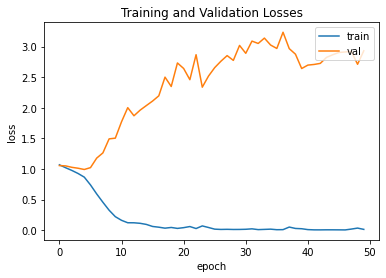

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and Validation Losses',size = 12)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [22]:
l = len(x_s_test)
_, balance2 = divmod(l,batch_size)
x_s_test = list(x_s_test)
fill_number = batch_size - balance2
for i in range(fill_number):
    x_s_test.append(np.zeros(sentence_maxlen,))
    print(len(x_s_test))
x_s_test = np.array(x_s_test)

178
179
180
181
182
183
184
185
186
187
188
189
190
191
192


In [23]:
y_pred = np.round(model2.predict(x_s_test, batch_size = 16))
print(classification_report(y_test, y_pred[:-fill_number], digits=4, labels = [0,1]))

              precision    recall  f1-score   support

           0     0.2963    0.2162    0.2500        37
           1     0.4368    0.5067    0.4691        75

   micro avg     0.4035    0.4107    0.4071       112
   macro avg     0.3665    0.3614    0.3596       112
weighted avg     0.3904    0.4107    0.3967       112
 samples avg     0.2599    0.2599    0.2599       112



/home/p/parush/.conda/envs/nlp/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/p/parush/.conda/envs/nlp/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
# cvscores = []

# for train, val in kfold.split(x_s, classes_[y_train.argmax(1)]): 
#     model2.fit(x_s[train], y_train[train], epochs = 5, batch_size = 16, verbose=1)
# #     scores = model2.evaluate(x_s[val], y_train[val], verbose=0)
# #     print("%s: %.2f%%" % (model2.metrics_names[1], scores[1]*100))
# #     cvscores.append(scores[1] * 100)
# # print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))





In [ ]:
#embeddings_weights = get_embeddings('wikipedia',300,vocabulary)


In [ ]:
# Do we have to do this?
# x_s_ = tf.convert_to_tensor(
#     x_s_, dtype=tf.float32, dtype_hint=None, name=None
# )

In [ ]:
# i = 0
# j = 16
# while j<=640:
#     inputs = x_t[i:j]
#     lstm = LSTM(128, return_sequences=True, return_state=True)
#     whole_seq_output, h_0, c_0 = lstm(inputs,initial_state = [h_0, c_0])
#     i += 16
#     j += 16



In [ ]:
# inputs = Input(batch_shape=(16,1,18))
# lstm = LSTM(128, return_sequences=True, return_state=True)
# whole_seq_output, h_0, c_0 = lstm(inputs)
# model = Model(inputs=inputs, outputs=whole_seq_output)
# k = model.predict(x_t[:640])

In [ ]:
# final_memory_state = tf.reshape(
#     final_memory_state, (16,1,128), name=None
# )

# final_carry_state = tf.reshape(
#     final_carry_state, (16,1,128), name=None
# )


In [ ]:

# inputs2 = Input(shape=(1,sentence_maxlen,), name = 'Input')
# #embedded_inputs = Embedding(embeddings_weights.shape[0], embeddings_weights.shape[1], weights=[embeddings_weights], name = 'Embedding')(inputs2)
# #embedded_inputs2 = Dropout(0.2)(embedded_inputs)
# lstm, s1,s2 = LSTM(128,return_sequences=True,return_state=True,dropout=0.3,name = 'lstm')(inputs2, initial_state = i_states)
# #lstm = LSTM(128,return_sequences=True,dropout=0.3,name = 'lstm')(inputs2)
# flat = Flatten(name = 'Flatten')(lstm)
# output = (Dense(3,activation='softmax',name = 'Dense'))(flat)
# model2 = Model(inputs=inputs2, outputs=output)
# model2.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])    
# model2.summary()


In [ ]:
# x_t =np.array( [x.reshape(1,18) for x in x_t[:640]])

# x_t = tf.convert_to_tensor(
#     x_t, dtype=tf.float32, dtype_hint=None, name=None
# )

# inputs_list = [tf.squeeze(x) for x in
#                 tf.split(1, sentence_maxlen, embedded_inputs)]